# Artificial Intelligence Project: Bjorn Rexhepi

This Notebook will present all the work that is done for the AI Project. The notebook includes all the necessary implementations that are done for creating a submission file for Kaggle. The goal is to be able to generate the best possible candidates for recommendation, in order to achieve good scores in Kaggle (URL: https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/submissions). The dataset that will be used for this project is the dataset of H&M Personalized Fashion Recommendations (https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/submissions). The source when this notebook was based on (https://github.com/radekosmulski/personalized_fashion_recs).

## 1. Setup

This section will include how we will setup the dataset in the notebook environment and applying the necessary imports.

In [4]:
import numpy as np 
import pandas as pd
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import string
import seaborn as sns
import matplotlib.pyplot as plt

In order to achieve a better perfomance in RAM and running time, we convert the CSV datasets into Feather format.

**Hint: If you have Feather files of the given datasets, it is recommended to avoid the conversion step of CSV files to Feather files of the cell below.**

In [ ]:
transactions = pd.read_csv('transactions_train.csv')
articles = pd.read_csv('articles.csv')
customers = pd.read_csv('customers.csv')
transactions.to_feather('transactions_train.feather')
articles.to_feather('articles.feather')
customers.to_feather('customers.feather')

In [5]:
articles = pd.read_feather('articles.feather')
customers = pd.read_feather('customers.feather')
transactions = pd.read_feather('transactions_train.feather')

In [3]:
!wget https://raw.githubusercontent.com/benhamner/Metrics/master/Python/ml_metrics/average_precision.py

--2022-12-16 19:44:26--  https://raw.githubusercontent.com/benhamner/Metrics/master/Python/ml_metrics/average_precision.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1654 (1.6K) [text/plain]
Saving to: ‘average_precision.py.1’

average_precision.p 100%[===================>]   1.62K  --.-KB/s    in 0s      

2022-12-16 19:44:26 (17.2 MB/s) - ‘average_precision.py.1’ saved [1654/1654]



## 2. Preprocessing

The preprocessor step is done, due to the fact to save memory usage and trying to achieve good scores in kaggle, by also applying some feature engineering in the datasets.

In [6]:
# helper functions from:
# https://github.com/radekosmulski/personalized_fashion_recs/blob/main/01_Solution_warmup.ipynb
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

# https://www.kaggle.com/c/h-and-m-personalized-fashion-recommendations/discussion/308635
def customer_hex_id_to_int(series):
    return series.str[-16:].apply(hex_id_to_int)

def hex_id_to_int(str):
    return int(str[-16:], 16)

def article_id_str_to_int(series):
    return series.astype('int32')

def article_id_int_to_str(series):
    return '0' + series.astype('str')

class Categorize(BaseEstimator, TransformerMixin):
    def __init__(self, min_examples=0):
        self.min_examples = min_examples
        self.categories = []
        
    def fit(self, X):
        for i in range(X.shape[1]):
            vc = X.iloc[:, i].value_counts()
            self.categories.append(vc[vc > self.min_examples].index.tolist())
        return self

    def transform(self, X):
        data = {X.columns[i]: pd.Categorical(X.iloc[:, i], categories=self.categories[i]).codes for i in range(X.shape[1])}
        return pd.DataFrame(data=data)

### 2.1 Preprocessing the transaction dataset
The weeks are determined as a feature engineering for simplicity in generating the candidates later (especially in the case when we consider the last week.)

In [7]:
transactions['customer_id'] = customer_hex_id_to_int(transactions['customer_id'])
transactions.t_dat = pd.to_datetime(transactions.t_dat, format='%Y-%m-%d')
transactions['week'] = (104 - (transactions.t_dat.max() - transactions.t_dat).dt.days // 7).astype(np.int8)
transactions.article_id = article_id_str_to_int(transactions.article_id)
articles.article_id = article_id_str_to_int(articles.article_id)

transactions.week = transactions.week.astype('int8')
transactions.sales_channel_id = transactions.sales_channel_id.astype('int8')
transactions.price = transactions.price.astype('float32')

In [8]:
transactions.drop(columns='t_dat').info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   customer_id       uint64 
 1   article_id        int32  
 2   price             float32
 3   sales_channel_id  int8   
 4   week              int8   
dtypes: float32(1), int32(1), int8(2), uint64(1)
memory usage: 545.7 MB


In [9]:
transactions

,t_dat,customer_id,article_id,price,sales_channel_id,week
0,2018-09-20,18439897732908966680,663713001,0.050831,2,0
1,2018-09-20,18439897732908966680,541518023,0.030492,2,0
2,2018-09-20,10112112306570742978,505221004,0.015237,2,0
3,2018-09-20,10112112306570742978,685687003,0.016932,2,0
4,2018-09-20,10112112306570742978,685687004,0.016932,2,0
...,...,...,...,...,...,...
31788319,2020-09-22,4685485978980270934,929511001,0.059305,2,104
31788320,2020-09-22,4685485978980270934,891322004,0.042356,2,104
31788321,2020-09-22,3959348689921271969,918325001,0.043203,1,104
31788322,2020-09-22,9807404028332039951,833459002,0.006763,1,104


### 2.2 Preprocessing the article dataset

In [10]:
for col in articles.columns:
    if articles[col].dtype == 'object':
        articles[col] = Categorize().fit_transform(articles[[col]])[col]

In [11]:
for col in articles.columns:
    if articles[col].dtype == 'int64':
        articles[col] = articles[col].astype('int32')

In [12]:
articles

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,12855,253,9,0,1010016,0,9,0,...,10,0,0,1,0,16,30,1002,2,8834
1,108775044,108775,12855,253,9,0,1010016,0,10,2,...,10,0,0,1,0,16,30,1002,2,8834
2,108775051,108775,44846,253,9,0,1010017,3,11,11,...,10,0,0,1,0,16,30,1002,2,8834
3,110065001,110065,8159,306,13,4,1010016,0,9,0,...,131,7,7,1,0,61,5,1017,4,8243
4,110065002,110065,8159,306,13,4,1010016,0,10,2,...,131,7,7,1,0,61,5,1017,4,8243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105537,953450001,953450,24043,302,14,7,1010014,6,9,0,...,153,2,2,3,3,26,16,1021,13,28026
105538,953763001,953763,24027,253,9,0,1010016,0,9,0,...,0,0,0,1,0,2,15,1005,0,28025
105539,956217002,956217,24040,265,1,2,1010016,0,9,0,...,0,0,0,1,0,18,12,1005,0,28024
105540,957375001,957375,24041,72,48,3,1010016,0,9,0,...,29,1,1,2,2,52,25,1019,1,28023


### 2.3 Preprocess of customer dataset

In [13]:
customers.customer_id = customer_hex_id_to_int(customers.customer_id)
for col in ['FN', 'Active', 'age']:
    customers[col].fillna(-1, inplace=True)
    customers[col] = customers[col].astype('int8')
customers.club_member_status = Categorize().fit_transform(customers[['club_member_status']]).club_member_status
customers.postal_code = Categorize().fit_transform(customers[['postal_code']]).postal_code
customers.fashion_news_frequency = Categorize().fit_transform(customers[['fashion_news_frequency']]).fashion_news_frequency

In [14]:
customers

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,6883939031699146327,-1,-1,0,0,49,6305
1,11246327431398957306,-1,-1,0,0,25,33726
2,18439897732908966680,-1,-1,0,0,24,3247
3,18352672461570950206,-1,-1,0,0,54,168643
4,18162778555210377306,1,1,0,1,52,168645
...,...,...,...,...,...,...,...
1371975,7551062398649767985,-1,-1,0,0,24,50351
1371976,9305341941720086711,-1,-1,0,0,21,80169
1371977,10160427316885688932,1,1,0,1,21,106737
1371978,2551401172826382186,1,1,0,1,18,111894


In [15]:
transactions.sort_values(['t_dat', 'customer_id'], inplace=True)

In [16]:
# This line of code is used to generate the preprocessed dataset of transactions, in order to be used for the validation step.
#transactions.reset_index().to_feather('transactions_train_preproc.feather')

## 3. Defining the last 10 weeks.

Here we determine the weeks that we are interested to generate candidates. The last weeks are most interesting to be considered, as we are more interested in the last behaviour of the users to make good recommendations.

In [17]:
test_week = transactions.week.max() + 1
transactions = transactions[transactions.week > transactions.week.max() - 10]

In [18]:
transactions

,t_dat,customer_id,article_id,price,sales_channel_id,week
29030503,2020-07-15,272412481300040,778064028,0.008458,1,95
29030504,2020-07-15,272412481300040,816592008,0.016932,1,95
29030505,2020-07-15,272412481300040,621381021,0.033881,1,95
29030506,2020-07-15,272412481300040,817477003,0.025407,1,95
29030507,2020-07-15,272412481300040,899088002,0.025407,1,95
...,...,...,...,...,...,...
31774722,2020-09-22,18439937050817258297,891591003,0.084729,2,104
31774723,2020-09-22,18439937050817258297,869706005,0.084729,2,104
31779097,2020-09-22,18440902715633436014,918894002,0.016932,1,104
31779098,2020-09-22,18440902715633436014,761269001,0.016932,1,104


In [19]:
transaction_weeks = transactions

In [20]:
transaction_weeks.sort_values(['week'], inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [21]:
transaction_weeks

,t_dat,customer_id,article_id,price,sales_channel_id,week
29030503,2020-07-15,272412481300040,778064028,0.008458,1,95
29203250,2020-07-19,10077993995051345471,879248008,0.016932,1,95
29203251,2020-07-19,10077993995051345471,699923098,0.007390,1,95
29203252,2020-07-19,10077993995051345471,774043004,0.011847,1,95
29203253,2020-07-19,10077993995051345471,699923092,0.008881,1,95
...,...,...,...,...,...,...
31623645,2020-09-18,5773606447362668780,873279005,0.042356,2,104
31623646,2020-09-18,5773606447362668780,909592001,0.013542,2,104
31623647,2020-09-18,5773606447362668780,909592002,0.013542,2,104
31616842,2020-09-18,5767640456585089046,908491005,0.025407,2,104


In this graph, we show which of the weeks had the highest number of transactions, so we can understand which part can be useful as a training data later on.

<AxesSubplot:>

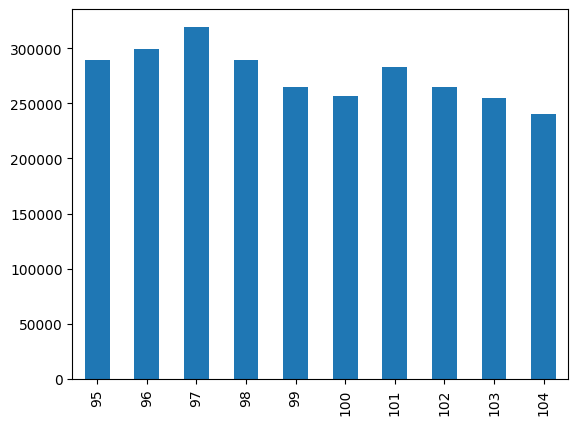

In [22]:
transaction_weeks['week'].value_counts().sort_index().plot.bar()

## 4. Candidate Generation

This step contains the process of generating the candidates, by applying some feature engineering.

### 4.1 Last purchase candidates

In [23]:
c2weeks = transactions.groupby('customer_id')['week'].unique()
c2weeks2shifted_weeks = {}

for c_id, weeks in c2weeks.items():
    c2weeks2shifted_weeks[c_id] = {}
    for i in range(weeks.shape[0]-1):
        c2weeks2shifted_weeks[c_id][weeks[i]] = weeks[i+1]
    c2weeks2shifted_weeks[c_id][weeks[-1]] = test_week
candidates_last_purchase = transactions.copy()
weeks = []
for i, (c_id, week) in enumerate(zip(transactions['customer_id'], transactions['week'])):
    weeks.append(c2weeks2shifted_weeks[c_id][week])
    
candidates_last_purchase.week=weeks

### 4.2 Bestseller candidates


In [24]:
mean_price = transactions \
    .groupby(['week', 'article_id'])['price'].mean()
sales = transactions \
    .groupby('week')['article_id'].value_counts() \
    .groupby('week').rank(method='dense', ascending=False) \
    .groupby('week').head(12).rename('bestseller_rank').astype('int8')
bestsellers_previous_week = pd.merge(sales, mean_price, on=['week', 'article_id']).reset_index()
bestsellers_previous_week.week += 1
unique_transactions = transactions \
    .groupby(['week', 'customer_id']) \
    .head(1) \
    .drop(columns=['article_id', 'price']) \
    .copy()
candidates_bestsellers = pd.merge(
    unique_transactions,
    bestsellers_previous_week,
    on='week',
)
test_set_transactions = unique_transactions.drop_duplicates('customer_id').reset_index(drop=True)
test_set_transactions.week = test_week
candidates_bestsellers_test_week = pd.merge(
    test_set_transactions,
    bestsellers_previous_week,
    on='week'
)
candidates_bestsellers = pd.concat([candidates_bestsellers, candidates_bestsellers_test_week])
candidates_bestsellers.drop(columns='bestseller_rank', inplace=True)

In [25]:
candidates_bestsellers.head()

,t_dat,customer_id,sales_channel_id,week,article_id,price
0,2020-07-26,11268931311315930183,2,96,760084003,0.025094
1,2020-07-26,11268931311315930183,2,96,866731001,0.024919
2,2020-07-26,11268931311315930183,2,96,600886001,0.022980
3,2020-07-26,11268931311315930183,2,96,706016001,0.033197
4,2020-07-26,11268931311315930183,2,96,372860002,0.013193


### 4.3 RecPack algorithms

In this section, the RecPack algorithms will be used to generate the candidates with the highest scores (confidence score for AR & SR).

In [26]:
from recpack.preprocessing.preprocessors import DataFramePreprocessor
from recpack.preprocessing.filters import MinItemsPerUser, MinUsersPerItem
from recpack.scenarios import Timed
from recpack.pipelines import PipelineBuilder

#### 4.3.1 Preprocessing the data with RecPack and creating the interaction matrix

In [27]:
proc = DataFramePreprocessor(item_ix='article_id', user_ix='customer_id', timestamp_ix='week')
proc.add_filter(MinUsersPerItem(10, item_ix='article_id', user_ix='customer_id'))
proc.add_filter(MinItemsPerUser(10, item_ix='article_id', user_ix='customer_id'))

interaction_matrix = proc.process(transactions)

  0%|          | 0/1228106 [00:00<?, ?it/s]

  0%|          | 0/1228106 [00:00<?, ?it/s]

#### 4.3.2 Association Rules algorithm

In [28]:
import pandas
import numpy as np
from scipy.sparse import csr_matrix
from recpack.algorithms.base import TopKItemSimilarityMatrixAlgorithm
from recpack.algorithms.util import invert
from recpack.matrix import InteractionMatrix, to_binary
from recpack.util import get_top_K_values, get_top_K_ranks


#def last_item_recommendations(X: InteractionMatrix):
    
#    return get_top_K_ranks(X.last_timestamps_matrix, K=1)


class AssociationRules(TopKItemSimilarityMatrixAlgorithm):
    def __init__(self, K=200):
        super().__init__(K)

    def _fit(self, X: csr_matrix):
        """
        Trains the predictor.

        """
        X_binary = to_binary(X)
        X_T_binary = csr_matrix(X_binary.transpose())

        # CO_matrix = X_T_binary @ X_binary

        CO_matrix = csr_matrix(X_T_binary @ X_binary)

        # Here we get the best rules
        CO_matrix = get_top_K_values(CO_matrix, self.K)
        
        # Normalization of CO_matrix
        CO_array = CO_matrix.toarray()
        
        diag = np.diagonal(CO_array)
        sim_matrix = CO_array/diag[:, None]
        # Top 10 rules for statistics!
        arr = sim_matrix
        np.fill_diagonal(arr,0)
        top_n = 10
        # Highest Similairity Values
        arr1d = arr.flatten()
        arr1d.sort()
        rslt = arr1d[-top_n : ]
        print(rslt, '\n')
        # LHS and RHS of top 10 rules
        idx = np.argpartition(arr, arr.size - top_n, axis=None)[-top_n:]
        result = np.column_stack(np.unravel_index(idx, arr.shape))
        print(result)
        similarity = csr_matrix(sim_matrix)
        # similarity = get_top_K_values(similarity, self.K)

        self.similarity_matrix_ = similarity

    #def _transform_predict_input(self, X):
    #    X = last_item_recommendations(X)
    #    return X

#### 4.3.3 Association Rules predicting only last item extension algorithm

In [29]:
import pandas
import numpy as np
from scipy.sparse import csr_matrix
from recpack.algorithms.base import TopKItemSimilarityMatrixAlgorithm
from recpack.algorithms.util import invert
from recpack.matrix import InteractionMatrix, to_binary
from recpack.util import get_top_K_values, get_top_K_ranks

def last_item_recommendations(X: InteractionMatrix):
    
    return get_top_K_ranks(X.last_timestamps_matrix, K=1)

class AssociationRulesExtensionLastItem(AssociationRules):
    def __init__(self, K=200):
        super().__init__(K)

    def _transform_predict_input(self, X):
        X = last_item_recommendations(X)
        return X

#### 4.3.4 Association Rules predicting the **k** recent purchased items extension algorithm

In [30]:
import pandas
import numpy as np
from scipy.sparse import csr_matrix
from recpack.algorithms.base import TopKItemSimilarityMatrixAlgorithm
from recpack.algorithms.util import invert
from recpack.matrix import InteractionMatrix, to_binary
from recpack.util import get_top_K_values, get_top_K_ranks

class AssociationRulesExtension(AssociationRules):
    def __init__(self, K=200, k_items = 200):
        super().__init__(K)
        self.k_items = k_items

    def _transform_predict_input(self, X):
        X = invert(get_top_K_ranks(X.last_timestamps_matrix, K=self.k_items))
        return X


#### 4.3.5 Sequential Rules algorithm

In [31]:
from asyncio.format_helpers import _format_callback_source
import pandas as pd
import numpy as np
from collections import Counter
from itertools import chain
from scipy.sparse import csr_matrix, lil_matrix
from recpack.algorithms.base import ItemSimilarityMatrixAlgorithm
from recpack.algorithms.util import invert
from recpack.matrix import InteractionMatrix, Matrix, to_csr_matrix
from recpack.matrix.interaction_matrix import InteractionMatrix
from recpack.util import to_binary


#def last_item_recommendations(X: InteractionMatrix):
    
#    return get_top_K_ranks(X.last_timestamps_matrix, K=1)


class SequentialRules(ItemSimilarityMatrixAlgorithm):
    def __init__(self, max_steps=20):
        self.max_steps = max_steps

    def _transform_fit_input(self, X: Matrix) -> InteractionMatrix:
        # X_interaction_matrix = isinstance(X, InteractionMatrix)
        if isinstance(X, InteractionMatrix) == False:
            raise ValueError(f"Interaction Matrix")
        elif X.has_timestamps == False:
            raise ValueError(f"requires timestamp information")
        else:
            return X

    def _fit(self, X: InteractionMatrix):
        a = list(X.sorted_item_history)
        sim_matrix = lil_matrix((X.shape[1], X.shape[1]))
        for user, items_per_user in X.sorted_item_history:
            for i in range(0, len(items_per_user) - 1):
                for n_steps, j in enumerate(
                    range(i + 1, min(len(items_per_user), i + self.max_steps + 1)),
                    start=1,
                ):
                    LHS = items_per_user[i]
                    RHS = items_per_user[j]
                    sim_matrix[LHS, RHS] += 1 / n_steps
        support = csr_matrix(X.values.sum(axis=0))

        sim_matrix = sim_matrix.multiply(invert(support).T)
        # Top 10 rules for statistics!
        #print(sim_matrix)
        arr = sim_matrix.toarray()
        np.fill_diagonal(arr,0)
        top_n = 10
        # Highest Similairity Values
        arr1d = arr.flatten()
        arr1d.sort()
        rslt = arr1d[-top_n : ]
        print(rslt, '\n')
        # LHS and RHS of top 10 rules
        idx = np.argpartition(arr, arr.size - top_n, axis=None)[-top_n:]
        result = np.column_stack(np.unravel_index(idx, arr.shape))
        print(result)
        self.similarity_matrix_ = sim_matrix.tocsr()

    #def _transform_predict_input(self, X):
    #    X = last_item_recommendations(X)
    #    return X


#### 4.3.6 Sequential Rules predicting only last item extension algorithm

In [32]:
from asyncio.format_helpers import _format_callback_source
import pandas as pd
import numpy as np
from collections import Counter
from itertools import chain
from scipy.sparse import csr_matrix, lil_matrix
from recpack.algorithms.base import ItemSimilarityMatrixAlgorithm
from recpack.algorithms.util import invert
from recpack.matrix import InteractionMatrix, Matrix, to_csr_matrix
from recpack.matrix.interaction_matrix import InteractionMatrix
from recpack.util import to_binary, get_top_K_ranks

def last_item_recommendations(X: InteractionMatrix):
    
    return get_top_K_ranks(X.last_timestamps_matrix, K=1)

class SequentialRulesExtensionLastItem(SequentialRules):
    def __init__(self, max_steps=20, k_items = 200):
        super().__init__(max_steps)
        self.k_items = k_items

    def _transform_predict_input(self, X):
        X = last_item_recommendations(X)
        return X

#### 4.3.7 Sequential Rules predicting the **k** recent purchased items extension algorithm

In [33]:
from asyncio.format_helpers import _format_callback_source
import pandas as pd
import numpy as np
from collections import Counter
from itertools import chain
from scipy.sparse import csr_matrix, lil_matrix
from recpack.algorithms.base import ItemSimilarityMatrixAlgorithm
from recpack.algorithms.util import invert
from recpack.matrix import InteractionMatrix, Matrix, to_csr_matrix
from recpack.matrix.interaction_matrix import InteractionMatrix
from recpack.util import to_binary, get_top_K_ranks


class SequentialRulesExtension(SequentialRules):
    def __init__(self, max_steps=20, k_items = 200):
        super().__init__(max_steps)
        self.k_items = k_items

    def _transform_predict_input(self, X):
        X = invert(get_top_K_ranks(X.last_timestamps_matrix, K=self.k_items))
        return X

#### 4.3.8 Registering the new implemented algorithms.

In [34]:
from recpack.pipelines import ALGORITHM_REGISTRY, PipelineBuilder, pipeline_builder

ALGORITHM_REGISTRY.register('AssociationRules', AssociationRules)
ALGORITHM_REGISTRY.register('SequentialRules', SequentialRules)
ALGORITHM_REGISTRY.register('AssociationRulesExLast', AssociationRulesExtensionLastItem)
ALGORITHM_REGISTRY.register('SequentialRulesExLast', SequentialRulesExtensionLastItem)
ALGORITHM_REGISTRY.register('AssociationRulesEx', AssociationRulesExtension)
ALGORITHM_REGISTRY.register('SequentialRulesEx', SequentialRulesExtension)

#### 4.3.9 Generating the confidence scores from AR algorithms

In this section, the confidence scores will be generated from the AR algorithms. Each version of it will be in seperated versions.

**Association Rules** (You can change the parameters before running it)

In [35]:
#ar = AssociationRules(K=100)
#ar.fit(interaction_matrix)

In [36]:
#pred_ar = ar.predict(interaction_matrix)

**Association Rules Extension (k most recent items)**

In [37]:
#are = AssociationRulesExtension(K=100, k_items=200)
#are.fit(interaction_matrix)

In [38]:
#pred_are = are.predict(interaction_matrix)

**Association Rules Extension last item**

In [39]:
#arl = AssociationRulesExtensionLastItem(K=100)
#arl.fit(interaction_matrix)

In [40]:
#pred_arl = arl.predict(interaction_matrix)

#### 4.3.10 Generating the confidence scores from SR algorithms

**Sequential Rules**

In [41]:
#sr = SequentialRules(max_steps=20)
#sr.fit(interaction_matrix)

In [42]:
#pred_sr = sr.predict(interaction_matrix)

**Sequential Rules Extension (k most recent items)**

In [43]:
sre = SequentialRulesExtension(max_steps=20, k_items=100)
sre.fit(interaction_matrix)

/opt/conda/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


[1.         1.         1.         1.         1.         1.
 1.         1.05934343 1.175      1.5       ] 

[[10856  6619]
 [14899  9610]
 [ 6803  6804]
 [17090 13159]
 [ 7150  1249]
 [16248 16145]
 [ 8899   879]
 [17113 12968]
 [18117 17274]
 [19471  5225]]
2022-12-23 13:23:45,857 - base - recpack - INFO - Fitting SequentialRulesExtension complete - Took 2.41e+02s


/home/jupyter/recpack/algorithms/base.py:271: UserWarning: SequentialRulesExtension missing similar items for 4 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")


SequentialRulesExtension(k_items=100)

In [44]:
pred_sre = sre.predict(interaction_matrix)

**Sequential Rules Extension last item**

In [45]:
#srl = SequentialRulesExtensionLastItem(max_steps=20)
#srl.fit(interaction_matrix)

In [46]:
#pred_srl = srl.predict(interaction_matrix)

### 4.4 Generating the confidence scores from the prediction done from each of the algorithms.

In [47]:
def top_n_idx_sparse(matrix: csr_matrix, n: int):
    """Return index of top n values in each row of a sparse matrix.
    source: https://stackoverflow.com/questions/49207275/finding-the-top-n-values-in-a-row-of-a-scipy-sparse-matrix
    """
    top_n_idx = []
    for le, ri in zip(matrix.indptr[:-1], matrix.indptr[1:]):
        n_row_pick = min(n, ri - le)
        if n_row_pick == n:
          top_n_idx.append(matrix.indices[le + np.argpartition(matrix.data[le:ri], -n_row_pick)[-n_row_pick:]].tolist())
    
    # Get the values corresponding to the indices
    top_n_values = []
    for row_idx, col_idxs in enumerate(top_n_idx):
        top_n_values.append(matrix[row_idx, col_idxs].toarray().tolist()[0])
        assert(len(top_n_values[row_idx]) == len(top_n_idx[row_idx]))
    return top_n_idx, top_n_values

In [48]:
#top_k_idx, top_k_values = top_n_idx_sparse(pred_ar, 12)
#top_k_idx, top_k_values = top_n_idx_sparse(pred_are, 12)
#top_k_idx, top_k_values = top_n_idx_sparse(pred_arl, 12)
#top_k_idx, top_k_values = top_n_idx_sparse(pred_sr, 12)
top_k_idx, top_k_values = top_n_idx_sparse(pred_sre, 12)
#top_k_idx, top_k_values = top_n_idx_sparse(pred_srl, 12)

In [49]:
# source of support: https://github.com/LienM/ai-project-22-23/blob/main/ArnoTroch/lecture6/submission-KNN-similarity-feature.ipynb
uid_cid_map = interaction_matrix._df[["uid", "customer_id"]].drop_duplicates().set_index("uid").to_dict()["customer_id"]
iid_aid_map = interaction_matrix._df[["iid", "article_id"]].drop_duplicates().set_index("iid").to_dict()["article_id"]

sr_customers = []
sr_articles = []
sr_scores = []

for i, row in enumerate(top_k_idx):
        user_predictions = [iid_aid_map[iid] for iid in row]
        sr_customers.extend([uid_cid_map[i]] * len(user_predictions))
        sr_articles.extend(user_predictions)
        sr_scores.extend(top_k_values[i])
sr_items = pd.DataFrame({"customer_id": sr_customers, "article_id": sr_articles, "sr_prediction": sr_scores})

In [50]:
sr_items

,customer_id,article_id,sr_prediction
0,272412481300040,908729002,0.023843
1,272412481300040,909357001,0.023998
2,272412481300040,850176003,0.044303
3,272412481300040,921906005,0.188091
4,272412481300040,854619003,0.059961
...,...,...,...
786439,6009256864929410070,921909001,0.119447
786440,6009256864929410070,868638003,0.196237
786441,6009256864929410070,825624003,0.112238
786442,6009256864929410070,903420001,0.231009


In [51]:
candidates_similar_items = pd.merge(
    sr_items,
    test_set_transactions,
    on='customer_id',
    how='left'
)

candidates_similar_items.drop(columns='sr_prediction', inplace=True)
last_price = transactions \
    .groupby(['article_id', 'week']) \
    .price \
    .last() \
    .reset_index() \
    .groupby('article_id') \
    .price \
    .last() \
    .reset_index()

candidates_similar_items = pd.merge(
    candidates_similar_items,
    last_price,
    on='article_id',
    how='left'
)

### 4.5 Time weighted popularity candidates

This feature engineering was based from Arno Troch work: https://github.com/LienM/ai-project-22-23/blob/main/ArnoTroch/lecture6/submission-KNN-similarity-feature.ipynb

In [52]:
popularity = transactions\
    .groupby(['article_id', 'week']).size().reset_index(name='weekly_purchase_count')
weekly_popularity = []
def func(row):
    weeks_before = popularity[(row.article_id == popularity.article_id) & (row.week > popularity.week)]
    # get last row of weeks_before
    previous_week_popularity = 0
    if weeks_before.shape[0] > 0:
        previous_week_popularity = weekly_popularity[-1]
    return previous_week_popularity / 2.0 + float(row.weekly_purchase_count)
# iterate over all rows
for i, row in popularity.iterrows():
    weekly_popularity.append(func(row))
popularity['weekly_popularity'] = weekly_popularity
popular_articles_per_week = popularity.sort_values(['week', 'weekly_popularity'], ascending=False)\
    .groupby('week').head(20).reset_index(drop=True)
popular_articles_previous_week = pd.merge(popular_articles_per_week, mean_price, on=['week', 'article_id']).reset_index(drop=True)
# make a new column to rank the weekly_popularity
popular_articles_previous_week['last_week_popularity_rank'] = popular_articles_previous_week.groupby('week')['weekly_popularity'].rank(ascending=False).astype(np.int32)
popular_articles_previous_week.week += 1

In [53]:
unique_transactions = transactions \
    .groupby(['week', 'customer_id']) \
    .head(1) \
    .drop(columns=['article_id', 'price']) \
    .copy()
candidates_most_popular = pd.merge(
    unique_transactions,
    popular_articles_previous_week,
    on='week',
)
test_set_transactions = unique_transactions.drop_duplicates('customer_id').reset_index(drop=True)
test_set_transactions.week = test_week
candidates_most_popular_test_week = pd.merge(
    test_set_transactions,
    popular_articles_previous_week,
    on='week'
)
candidates_most_popular_test_week.head()

,t_dat,customer_id,sales_channel_id,week,article_id,weekly_purchase_count,weekly_popularity,price,last_week_popularity_rank
0,2020-07-15,272412481300040,1,105,924243001,852,1236.875000,0.041535,1
1,2020-07-15,272412481300040,1,105,909370001,537,1190.500000,0.032640,2
2,2020-07-15,272412481300040,1,105,751471001,526,1173.253906,0.033423,3
3,2020-07-15,272412481300040,1,105,918522001,609,1064.500000,0.041435,4
4,2020-07-15,272412481300040,1,105,448509014,490,1004.210938,0.041630,5


In [54]:
candidates_most_popular = pd.concat([candidates_most_popular, candidates_most_popular_test_week])
candidates_most_popular.drop(columns=['weekly_purchase_count', 'weekly_popularity', 'last_week_popularity_rank'], inplace=True)
candidates_most_popular.head()

,t_dat,customer_id,sales_channel_id,week,article_id,price
0,2020-07-26,11268931311315930183,2,96,760084003,0.025094
1,2020-07-26,11268931311315930183,2,96,866731001,0.024919
2,2020-07-26,11268931311315930183,2,96,600886001,0.022980
3,2020-07-26,11268931311315930183,2,96,706016001,0.033197
4,2020-07-26,11268931311315930183,2,96,372860002,0.013193


## 5. Combining transactions and candidates / negative examples

**Note:** When combining the transactions with the candidates, in this notebook we present two ways of combinations.

      1. Candidates with the highest confidence score.
      2. Last week besteller popularity rank with the most popular items.

As there are many algorithms to test out, based on the previous experiments, only the second one generated the best results. The procedure to follow the first one will be the same.

In [55]:
transactions['purchased'] = 1
#data = pd.concat([transactions, candidates_last_purchase, candidates_similar_items])
data = pd.concat([transactions, candidates_last_purchase, candidates_bestsellers, candidates_most_popular])
data.purchased.fillna(0, inplace=True)

data.purchased.mean()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0.06700912511083817

In [56]:
data.drop_duplicates(['customer_id', 'article_id', 'week'], inplace=True)

### 5.1 Adding besteller information

In [57]:
data = pd.merge(
    data,
    bestsellers_previous_week[['week', 'article_id', 'bestseller_rank']],
    on=['week', 'article_id'],
    how='left'
)
data = data[data.week != data.week.min()]

### 5.2 Adding AR (SR if we run SR) items information

In [58]:
data = pd.merge(
    data, 
    sr_items[['customer_id', 'article_id', 'sr_prediction']], 
    on=['customer_id', 'article_id'], 
    how='left'
)

### 5.3 Adding popularity information

In [59]:
data = pd.merge(
    data,
    popular_articles_previous_week[['week', 'article_id', 'weekly_purchase_count', 'weekly_popularity', 'last_week_popularity_rank']],
    on=['week', 'article_id'],
    how='left'
)

In [60]:
data = pd.merge(data, articles, on='article_id', how='left')
data = pd.merge(data, customers, on='customer_id', how='left')

data['weekly_purchase_count'].fillna(0, inplace=True)
data['weekly_popularity'].fillna(0, inplace=True)
data['sr_prediction'].fillna(data['purchased'], inplace=True)
data['bestseller_rank'].fillna(data.bestseller_rank.max() + 1, inplace=True)
data['last_week_popularity_rank'].fillna(data.last_week_popularity_rank.max() + 1, inplace=True)
data.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased,bestseller_rank,sr_prediction,weekly_purchase_count,...,section_name,garment_group_no,garment_group_name,detail_desc,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,2020-07-26,11268931311315930183,624486064,0.013542,2,96,1.0,13.0,1.0,0.0,...,27,1002,2,86,-1,-1,0,0,29,22417
1,2020-07-26,11269630911187963830,854305001,0.067780,2,96,1.0,13.0,1.0,0.0,...,20,1020,7,15975,-1,-1,0,0,51,22034
2,2020-07-26,11261591757361345977,720504004,0.033881,2,96,1.0,13.0,1.0,0.0,...,46,1016,11,95,1,1,0,1,52,185988
3,2020-07-26,11275517746704404193,816908001,0.033881,2,96,1.0,13.0,1.0,0.0,...,37,1016,11,23357,1,1,0,1,54,198
4,2020-07-26,11275517746704404193,825533001,0.024390,2,96,1.0,13.0,1.0,0.0,...,37,1016,11,25571,1,1,0,1,54,198


### 5.4 Preprocessing step

In [61]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
scaler = StandardScaler()
columns_to_scale = ['product_type_no', 'graphical_appearance_no', 'colour_group_code', 'perceived_colour_value_id',
'perceived_colour_master_id', 'department_no', 'index_code',
'index_group_no', 'section_no', 'garment_group_no', 'FN', 'Active',
'club_member_status', 'fashion_news_frequency', 'age', 'postal_code', 'last_week_popularity_rank', 'sr_prediction']
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])
data.sort_values(['week', 'customer_id'], inplace=True)
data.reset_index(drop=True, inplace=True)
train = data[data.week != test_week]
test = data[data.week==test_week].drop_duplicates(['customer_id', 'article_id', 'sales_channel_id']).copy()
train_baskets = train.groupby(['week', 'customer_id'])['article_id'].count().values
columns_to_use = ['article_id', 'product_type_no', 'graphical_appearance_no', 'colour_group_code', 'perceived_colour_value_id',
'perceived_colour_master_id', 'department_no', 'index_code',
'index_group_no', 'section_no', 'garment_group_no', 'FN', 'Active',
'club_member_status', 'fashion_news_frequency', 'age', 'postal_code', 'last_week_popularity_rank', 'sr_prediction']

In [62]:
train_X = train[columns_to_use]
train_y = train['purchased']

test_X = test[columns_to_use]

## 6. Model Training

In [63]:
from lightgbm.sklearn import LGBMRanker
ranker = LGBMRanker(
    objective="lambdarank",
    num_leaves=200,
    metric="ndcg",
    boosting_type="dart",
    n_estimators=100,
    importance_type='gain',
    verbose=10,
)

ranker = ranker.fit(
    train_X,
    train_y,
    group=train_baskets,
)

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.858157
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.135498
[LightGBM] [Debug] init for col-wise cost 0.413779 seconds, init for row-wise cost 0.845700 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.644160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1388
[LightGBM] [Info] Number of data points in the train set: 18461334, number of used features: 19
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 200 and depth = 15
[Lig

In [64]:
for i in ranker.feature_importances_.argsort()[::-1]:
    print(columns_to_use[i], ranker.feature_importances_[i]/ranker.feature_importances_.sum())

sr_prediction 0.9922907190300218
last_week_popularity_rank 0.0031548695490057044
article_id 0.0010514141910338394
department_no 0.0008443196881798013
product_type_no 0.0006851708014688439
colour_group_code 0.0003746481932520576
garment_group_no 0.00029170530588920244
section_no 0.0002901976691868278
graphical_appearance_no 0.00022600056787867891
perceived_colour_master_id 0.0002035718357024699
postal_code 0.0001642853400688933
age 0.0001488989738856507
perceived_colour_value_id 0.00012873791485893928
index_code 9.074981111667801e-05
index_group_no 4.11595203075951e-05
FN 4.865044445518244e-06
Active 3.919402170443539e-06
fashion_news_frequency 3.4755415916672246e-06
club_member_status 1.291619935440677e-06


## 7. Calculate Predictions

In [65]:
test['preds'] = ranker.predict(test_X)

c_id2predicted_article_ids = test \
    .sort_values(['customer_id', 'preds'], ascending=False) \
    .groupby('customer_id')['article_id'].apply(list).to_dict()

bestsellers_last_week = \
    bestsellers_previous_week[bestsellers_previous_week.week == bestsellers_previous_week.week.max()]['article_id'].tolist()

## 8. Create submissions

In [151]:
sub = pd.read_csv('sample_submission.csv')

In [152]:
preds = []
for c_id in customer_hex_id_to_int(sub.customer_id):
    predd = c_id2predicted_article_ids.get(c_id, [])
    predd = predd + bestsellers_last_week
    preds.append(predd[:12])

In [153]:
preds = [' '.join(['0' + str(p) for p in ps]) for ps in preds]
sub.prediction = preds

In [154]:
sub.to_csv('submission_ar_ex_k100_ki_200.csv.gz', index=False)

## 9. Evaluating the validation of the model

In [66]:
from collections import defaultdict

val_week_purchases_by_cust = defaultdict(list)

val_week_purchases_by_cust.update(
    transactions[transactions.week == transactions.week.max()] \
        .groupby('customer_id')['article_id'] \
        .apply(list) \
        .to_dict()
)

pd.to_pickle(dict(val_week_purchases_by_cust), 'val_week_purchases_by_cust.pkl')

sample_sub = pd.read_csv('sample_submission.csv')
valid_gt = customer_hex_id_to_int(sample_sub.customer_id) \
    .map(val_week_purchases_by_cust) \
    .apply(lambda xx: ' '.join('0' + str(x) for x in xx))

sample_sub.prediction = valid_gt
sample_sub.to_parquet('validation_ground_truth.parquet', index=False)

In [67]:
from average_precision import apk

def calculate_apk(list_of_preds, list_of_gts):
    # for fast validation this can be changed to operate on dicts of {'cust_id_int': [art_id_int, ...]}
    # using 'data/val_week_purchases_by_cust.pkl'
    apks = []
    for preds, gt in zip(list_of_preds, list_of_gts):
        apks.append(apk(gt, preds, k=12))
    return np.mean(apks)

def eval_sub(sub_csv, skip_cust_with_no_purchases=True):
    sub=pd.read_csv(sub_csv)
    validation_set=pd.read_parquet('data/validation_ground_truth.parquet')

    apks = []

    no_purchases_pattern = []
    for pred, gt in zip(sub.prediction.str.split(), validation_set.prediction.str.split()):
        if skip_cust_with_no_purchases and (gt == no_purchases_pattern): continue
        apks.append(apk(gt, pred, k=12))
    return np.mean(apks)

In [68]:
apks = []

for c_id, gt in val_week_purchases_by_cust.items():
    pred = c_id2predicted_article_ids.get(c_id, [])
    pred = pred + bestsellers_last_week
    apks.append(apk(gt, pred[:12]))

np.mean(apks)

0.046851296625409634

In [2]:


#0.04646316466464862 - SR_EX, m=20, ki=500, best_seller
#0.03983189892009947 - SR, m=100, sr_cand
#0.04662638568461804 - SR, m=100, best_seller
#0.03625735550211291 - AR, k=500, ar_cand
#0.03984894802352050 - SR, m=20, sr_cand
#0.035727969452068235- AR, k=100, ar_cand
#0.04662715038646773 - SR, m=20, best_seller
#0.04272341816934913 - AR, k=100, best_seller
#0.04319576456946244 - AR, k=500, best_seller
#0.03638221089133672 - AR_EXL, k=100, arcand
#0.03728892873638925 - SR_EXL, m=30, arcand
#0.026080221407136228 - AR_EXL, k=100, bestseller
#0.03579298333440158 - AR_EXL, k=2000, arcand
#0.04276218941101030 - AR_EX, k=100, ki=100
#0.026645830162531175 - SR_EXL, m=30
#0.04276007935901461 - AR_EX, k=100, ki=200
#0.02667878279996387 - SR_EXL, m=100
#0.04686452183462344 - SR_EX, k=100, m=100

## 10. Plot of the MAP@12 validation scores for AR & SR (the most important ones to define the differences among the algorithms and )

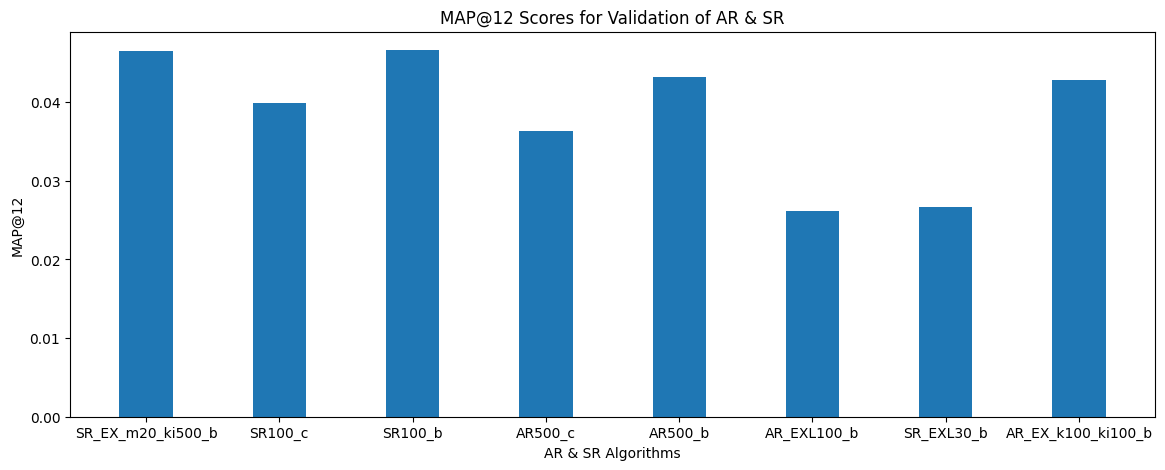

In [161]:
#https://www.geeksforgeeks.org/bar-plot-in-matplotlib/
import numpy as np
import matplotlib.pyplot as plt
  
#creating the dataset
data = {'SR_EX_m20_ki500_b':0.046463, 'SR100_c':0.039831, 'SR100_b':0.046626,
        'AR500_c':0.036257, 'AR500_b':0.043195, 'AR_EXL100_b':0.026080, 'SR_EXL30_b':0.026645,
        'AR_EX_k100_ki100_b':0.042762}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (14, 5))
 
# creating the bar plot
plt.bar(courses, values,
        width = 0.4)
 
plt.xlabel("AR & SR Algorithms")
plt.ylabel("MAP@12")
plt.title("MAP@12 Scores for Validation of AR & SR")
plt.show()